# Detecting change in Australian forestry <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)

## Background
Effective management of Australia's forests is critical for balancing environmental protection and sustainable growth of the industry.
Methods for detecting meaningful and significant change in forests are important for those who manage and monitor large areas of forest.

On-the-ground monitoring can be expensive and time-consuming, especially when forests are in difficult-to-navigate terrain.
Aerial photography and LiDAR can provide detailed information about forests, but are often extremely expensive to acquire, even over small areas.

### Sentinel-2 use case
Satellite imagery from the [EU Copernicus Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) is freely available and has a revisit time over Australia of ~5 days.
Its 10 metre resolution makes it perfect for monitoring fine changes over very large areas of land.
The archive of Sentinel-2 data stretches back to 2015, meaning that there is a good amount of data for change detection, allowing us to average out or focus on seasonal changes.

## Description
In this example, we measure the presence of vegetation from Sentinel-2 imagery and apply a hypothesis test to identify areas of significant change (along with the direction of the change).
The worked example takes users through the code required to do the following:

1. Load cloud-free Sentinel-2 images for an area of interest
2. Compute an index to highlight presence of vegetation (NDVI)
3. Apply a statistical hypothesis test to find areas of significant change
4. Visualise the statistically significant areas.

***

## Getting started

**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
Load key Python packages and any supporting functions for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_bandindices import calculate_indices
from dea_plotting import display_map
from dea_plotting import rgb

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Change_detection")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
There is also a parameter to define how the data is split in time; the split yields two non-overlapping samples, which is a requirement of the hypothesis test we want to run (more detail below).
The parameters are:

* `latitude`: The latitude range to analyse (e.g. `(-35.271, -35.331)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `longitude`: The longitude range to analyse (e.g. `(149.256, 149.356)`).
For reasonable loading times, make sure the range spans less than ~0.1 degrees.
* `time`: The date range to analyse (e.g. `('2015-01-01', '2019-09-01')`).
Note that Sentinel-2 data is not available in Australia prior to 2015.
For reasonable results, the range should span at least two years to prevent detecting seasonal changes.
* `time_baseline`: The date at which to split the total sample into two non-overlapping samples (e.g. `'2017-12-01'`).
For reasonable results, pick a date that is about halfway between the start and end dates specified in `time`.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers the Kowen Forest, a commercial pine plantation in the Australian Capital Territory.

**To run the notebook for a different area**, make sure Sentinel-2 data is available for the chosen area using the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule).
Use the drop-down menu to check both Sentinel-2A (`s2a_ard_granule`) and Sentinel-2B (`s2b_ard_granule`).

In [3]:
# Define the area of interest
latitude = (-35.271, -35.331)
longitude = (149.256, 149.356)

# Set the range of dates for the complete sample
time = ('2015-01-01', '2019-09-01')

# Set the date to separate the data into two samples for comparison
time_baseline = '2017-12-01'

## View the selected location
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [4]:
display_map(x=longitude, y=latitude)

## Load and view Sentinel-2 data

The first step in the analysis is to load Sentinel-2 data for the specified area of interest and time range.
This uses the pre-defined `load_ard` utility function.
This function will automatically mask any clouds in the dataset, and only return images where more than 70% of the pixels were classified as clear.
When working with Sentinel-2, the function will also combine and sort images from both Sentinel-2A and Sentinel-2B.

**Please be patient**.
The data may take a few minutes to load and progress will be indicated by text output.
The load is complete when the cell status goes from `[*]` to `[number]`.

In [5]:
# Choose products to load
# Here, the Sentinel-2A and Sentinel-2B products are chosen
products = ['s2a_ard_granule', 's2b_ard_granule']

# Specify the parameters to pass to the load query
query = {
    "x": longitude,
    "y": latitude,
    "time": time,
    "measurements": [
        "nbart_red",  # Red band
        "nbart_green",  # Green band
        "nbart_blue",  # Blue band
        "nbart_nir_1",  # Near-infrared band
#         "fmask"  # Cloud masking band
    ],
    "output_crs": "EPSG:3577",
    "resolution": (-10, 10)
}

# Load the data
ds_s2 = load_ard(dc, products=products, min_gooddata=0.7, **query)

Loading s2a_ard_granule data
    Filtering to 64 out of 132 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 39 out of 78 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 103 observations 


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the x (longitude) and y (latitude) dimensions.

In [6]:
print(ds_s2)

<xarray.Dataset>
Dimensions:      (time: 103, x: 990, y: 784)
Coordinates:
  * x            (x) float64 1.561e+06 1.561e+06 ... 1.571e+06 1.571e+06
  * y            (y) float64 -3.958e+06 -3.958e+06 ... -3.966e+06 -3.966e+06
  * time         (time) datetime64[ns] 2015-09-13T00:06:33.742500 ... 2019-08-28T00:02:49.024000
Data variables:
    nbart_red    (time, y, x) float32 643.0 503.0 496.0 ... 724.0 678.0 737.0
    nbart_green  (time, y, x) float32 543.0 494.0 459.0 ... 641.0 518.0 605.0
    nbart_blue   (time, y, x) float32 423.0 359.0 349.0 ... 409.0 378.0 439.0
    nbart_nir_1  (time, y, x) float32 1877.0 1437.0 1447.0 ... 2152.0 2314.0
Attributes:
    crs:      EPSG:3577


### Plot example timestep in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step.
White spots in the images are where clouds have been masked out.

The settings below will display images for two time steps, one in early January 2016, one in late December 2018.
Can you spot any areas of change?

Feel free to experiement with the values for the `initial_timestep` and `final_timestep` variables; re-run the cell to plot the images for the new timesteps.
The values for the timesteps can be `0` to one fewer than the number of time steps loaded in the data set.
The number of time steps is the same as the total number of observations listed as the output of the cell used to load the data.

> **Note:** If the location and time are changed, you may need to change the `intial_timestep` and `final_timestep` parameters to view images at similar times of year.

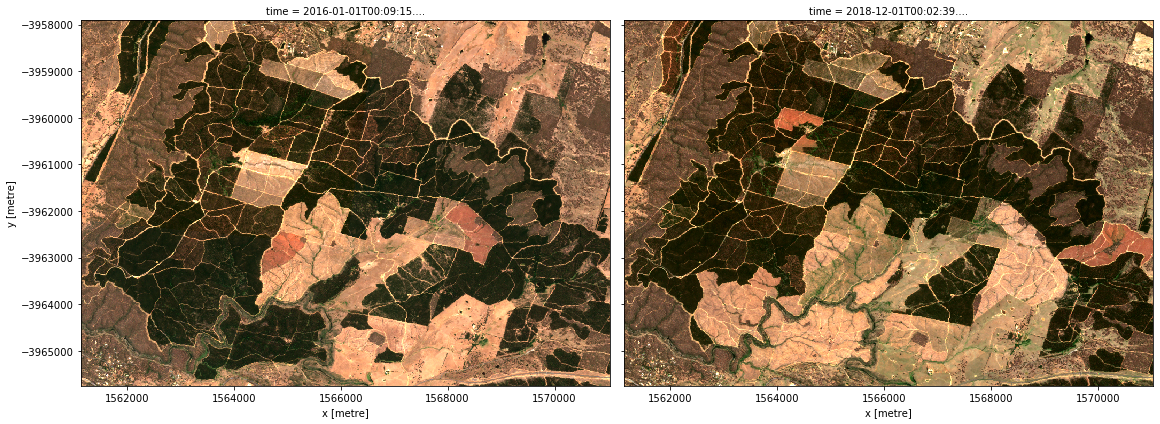

In [7]:
# Set the timesteps to visualise
initial_timestep = 1
final_timestep = 76

# Generate RGB plots at each timestep
rgb(ds_s2, index=[initial_timestep, final_timestep])

## Compute band indices
This study measures vegetation through the normalised difference vegetation index (NDVI), which can be calculated using the predefined `calculate_indices` utility function.
This index uses the ratio of the red and near-infrared (NIR) bands to identify live green vegetation. 
The formula is

$$
\begin{aligned}
\text{NDVI} = \frac{\text{NIR} - \text{Red}}{\text{NIR} + \text{Red}}.
\end{aligned}
$$

When interpreting this index, high values indicate vegetation, and low values indicate soil or water.

In [8]:
# Calculate NDVI and add it to the loaded dataset
ds_s2 = calculate_indices(ds_s2, 'NDVI', collection='ga_s2_1')

The plots below show the NDVI values for the two selected timesteps used to make the true-colour images above.
Use the plots to visually confirm whether NDVI is a suitable index for change detection.

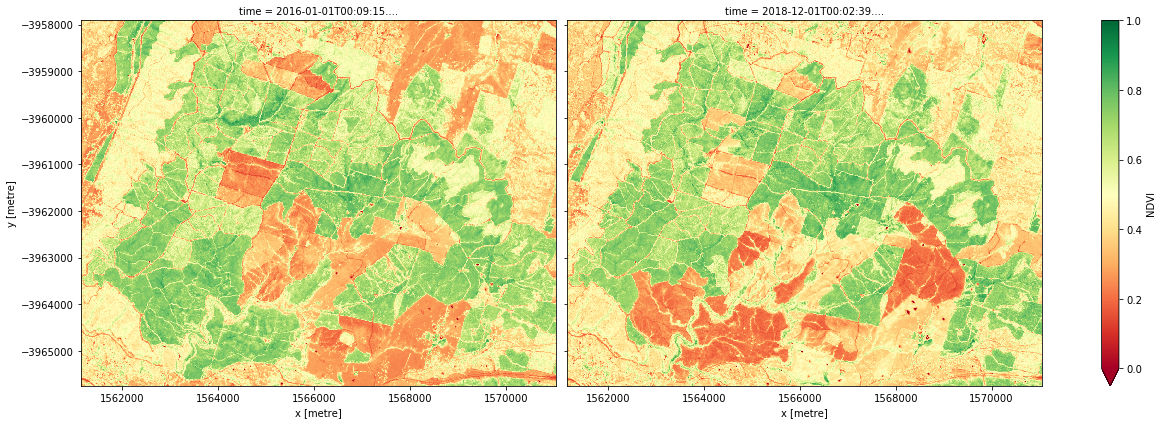

In [9]:
# Plot the NDVI values for pixels classified as water for the two dates.
ds_s2.NDVI.isel(time=[initial_timestep, final_timestep]).plot.imshow(
    'x', 'y', col='time', cmap='RdYlGn', vmin=0, vmax=1, figsize=(18, 6))

plt.show()

## Perform hypothesis test
While it is possible to visually detect change between the `2016-01-01` and `2018-12-26` timesteps, it is important to consider how to rigorously check for both positive change in the NDVI (afforestation) and negative change in the NDVI (deforestation).

This can be done through hypothesis testing.
In this case, 

$$
\begin{aligned}
\text{null hypothesis } (H_0) &: \text{no change occurred,} \\
\text{alternative hypothesis } (H_1) &: \text{some change occurred.}
\end{aligned}
$$

The hypothesis test will indicate where there is evidence for rejecting the null hypothesis.
From this, we may identify areas of signficant change, according to a given significance level (covered in more detail below).

### Make samples

To perform the test, the total sample will be split in two: a `baseline` sample and a `postbaseline` sample, which respectively contain the data before and after the `time_baseline` date.
Then, we can test for a difference in the average NDVI between the samples for each pixel in the sample.

The samples are made by selecting the `NDVI` band from the dataset and filtering it based on whether it was observed before or after the `time_baseline` date.
The number of observations in each sample will be printed.
If one sample is much larger than the other, consider changing the `time_baseline` parameter in the "Analysis parameters" cell, and then re-run this cell.
Coordinates are recorded for later use.

In [10]:
# Make samples
baseline_sample = ds_s2.NDVI.sel(time=ds_s2['time']<=np.datetime64(time_baseline))
print(f"Number of observations in baseline sample: {len(baseline_sample.time)}")

postbaseline_sample = ds_s2.NDVI.sel(time=ds_s2['time']>np.datetime64(time_baseline))
print(f"Number of observations in postbaseline sample: {len(postbaseline_sample.time)}")

# Record coodrinates for reconstructing xarray objects
sample_lat_coords = ds_s2.coords['y']
sample_lon_coords = ds_s2.coords['x']

Number of observations in baseline sample: 41
Number of observations in postbaseline sample: 62


### Test for change
To look for evidence that the average NDVI has changed between the two samples (either positively or negatively), we use Welch's t-test.
This is used to test the hypothesis that two populations have equal averages.
In this case, the populations are the area of interest before and after the `time_baseline` date, and the average being tested is the average NDVI.
Welch's *t*-test is used (as opposed to Student's *t*-test) because the two samples in the study may not necessarily have equal variances. 

The test is run using the Scipy package's statistcs library, which provides the `ttest_ind` function for running *t*-tests. 
Setting `equal_var=False` means that the function will run Welch's *t*-test.
The function returns the *t*-statistic and *p*-value for each pixel after testing the difference in the average NDVI.
These are stored as `t_stat` and `p_val` inside the `t_test` dataset for use in the next section.

In [11]:
# Perform the t-test on the postbaseline and baseline samples
tstat, p_tstat = stats.ttest_ind(
    postbaseline_sample.values,
    baseline_sample.values,
    equal_var=False,
    nan_policy='omit',
)

# Convert results to an xarray for further analysis
t_test = xr.Dataset(
    {
        't_stat': (['y', 'x'], tstat),
        'p_val': (['y', 'x'], p_tstat)
    },
    coords={
        'x': (['x'], sample_lon_coords.values),
        'y': (['y'], sample_lat_coords.values)
    }, 
    attrs={
        'crs': 'EPSG:3577',
    })

print(t_test)

<xarray.Dataset>
Dimensions:  (x: 990, y: 784)
Coordinates:
  * x        (x) float64 1.561e+06 1.561e+06 1.561e+06 ... 1.571e+06 1.571e+06
  * y        (y) float64 -3.958e+06 -3.958e+06 ... -3.966e+06 -3.966e+06
Data variables:
    t_stat   (y, x) float64 -0.525 -0.4284 -0.9775 -0.6942 ... 6.372 6.523 6.276
    p_val    (y, x) float64 0.6016 0.67 0.3325 ... 2.725e-08 1.115e-08 4.636e-08
Attributes:
    crs:      EPSG:3577


## Visualise change
From the test, we're interested in two conditions: whether the change is significant (rejection of the null hypothesis) and whether the change was positive (afforestation) or negative (deforestation).

The null hypothesis can be rejected if the $p$-value (`p_val`) is less than the chosen significance level, which is set as `sig_level = 0.05` for this analysis.
If the null hypothesis is rejected, the pixel will be classified as having undergone significant change.

The direction of the change can be inferred from the difference in the average NDVI of each sample, which is calculated as $$\text{diff mean} = \text{mean(post baseline)} - \text{mean(baseline)}.$$
This means that:

* if the average NDVI for a given pixel is **higher** in the `post baseline` sample compared to the `baseline` sample, then `diff_mean` for that pixel will be **positive**.
* if the average NDVI for a given pixel is **lower** in the `post baseline` sample compared to the `baseline` sample, then `diff_mean` for that pixel will be **negative**.

Run the cell below to first plot the difference in the mean between the two samples, then plot only the differences that were marked as signficant. 
**Positive change is shown in blue and negative change is shown in red.**

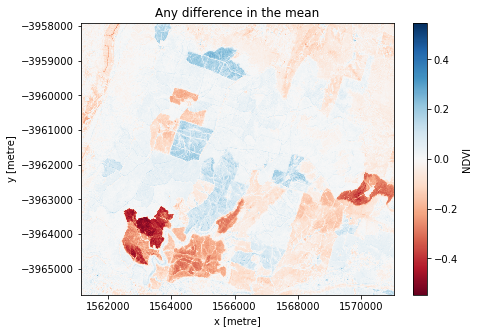

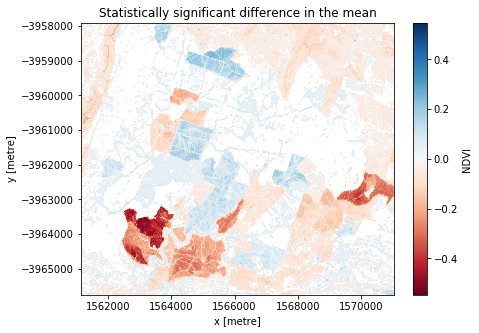

In [12]:
# Set the significance level
sig_level = 0.05

# Plot any difference in the mean
diff_mean = postbaseline_sample.mean(dim=['time']) - baseline_sample.mean(dim=['time'])

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
diff_mean.plot(cmap='RdBu')
ax.set_title('Any difference in the mean')
plt.show()

# Plot any difference in the mean classified as significant
sig_diff_mean = postbaseline_sample.mean(dim=['time']).where(t_test.p_val < sig_level) - baseline_sample.mean(dim=['time']).where(t_test.p_val < sig_level)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sig_diff_mean.plot(cmap='RdBu')
ax.set_title('Statistically significant difference in the mean')
plt.show()

## Drawing conclusions
Here are some questions to think about:

* What has happened in the forest over the time covered by the dataset?
* Were there any statistically significant changes that the test found that you didn't see in the true-colour images? 
* What kind of activities/events might explain the significant changes?
* What kind of activities/events might explain non-significant changes?
* What other information might you need to draw conclusions about the cause of the statistically significant changes?

## Export the data
To explore the data further in a desktop GIS program, the data can be output as a GeoTIFF.
This requires data to be converted to an xarray and tagged with the appropriate coordinate reference system (`crs`). 
The `diff_mean` product will be saved as "ttest_diff_mean.tif", and the `sig_diff_mean` product will be saved as "ttest_sig_diff_mean.tif".
These files can be downloaded from the file explorer to the left of this window ([see these instructions](https://jupyterlab.readthedocs.io/en/stable/user/files.html#uploading-and-downloading)).

In [13]:
# Make datasets into xarrays for output
diff_mean_out = xr.Dataset({'diff_mean': diff_mean}, attrs={'crs': CRS('EPSG:3577')})
sig_diff_mean_out = xr.Dataset({'sig_diff_mean': sig_diff_mean}, attrs={'crs': CRS('EPSG:3577')})

# Write output to geotiffs
write_geotiff(filename="ttest_diff_mean.tif", dataset=diff_mean_out)
write_geotiff(filename="ttest_sig_diff_mean.tif", dataset=sig_diff_mean_out)

## Next steps

When you are done, return to the "Analysis parameters" section, modify some values (e.g. `latitude`, `longitude`, `time` or `time_baseline`) and re-run the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

If you're going to change the location, you'll need to make sure Sentinel-2 data is available for the new location, which you can check at the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule).
Use the drop-down menu to check both Sentinel-2A (`s2a_ard_granule`) and Sentinel-2B (`s2b_ard_granule`). 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)